In [1]:
import sys
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd
import numba as nb
import math
import ffmpeg
plt.rcParams['animation.ffmpeg_path'] = '/Users/zach/.virtualenvs/model1/lib/python3.9/site-packages/ffmpeg/'
sys.path.append('../')
from model import Model, feedforward_signal, feedback_interp
from image_generation import generate_block #, generate_2_blocks
from scipy import signal, ndimage
from copy import deepcopy
from utils import extract_window, gaussian_1d, gaussian_kernel, runge_kutta2_step #, border_detection

from scipy import signal, ndimage, interpolate
from functools import partial
import cProfile
from pathlib import Path

import matplotlib.animation as animation
import matplotlib as mpl
# from matplotlib import rc
# rc('animation', html='jshtml')
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg')
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png')
cmap='plasma'
np.set_printoptions(precision=4)

In [2]:
parm_df = pd.read_csv("../parameters.csv", index_col=0)
parm_df.loc['k2'] = [0,0,0,0]
parm_df.loc['g8'] = [0,0,0,0]
print(parm_df.loc['k2'])

fg = 45
bg = 135
na = generate_block(bg_orientation=bg, figure_orientation=fg)

model = Model(parm_df,
             features=[bg,fg])

LGN = {"V": [], "W": []}
V1 = {"V": [], "W": [], "U": [], "D": []}
V2 = {"V": [], "W": [], "U": [], "D": []}
V4 = {"V": [], "W": [], "U": [], "D": []}


for i in range(600):
    if i < 40:
        model.update(None, 10e-3)
    else:
        model.update(na, 10e-3)
        
    LGN['V'].append(np.array([model.LGN[f].V for f in range(len(model.features))]))
    LGN['W'].append(np.array([model.LGN[f].W for f in range(len(model.features))]))
    
    V1['V'].append(np.array([model.V1[f].V for f in range(len(model.features))]))
    V1['W'].append(np.array([model.V1[f].W for f in range(len(model.features))]))
    V1['U'].append(np.array([model.V1[f].U for f in range(len(model.features))]))
    V1['D'].append(np.array([model.V1[f].D for f in range(len(model.features))]))
    
    V2['V'].append(np.array([model.V2[f].V for f in range(len(model.features))]))
    V2['W'].append(np.array([model.V2[f].W for f in range(len(model.features))]))
    V2['U'].append(np.array([model.V2[f].U for f in range(len(model.features))]))
    V2['D'].append(np.array([model.V2[f].D for f in range(len(model.features))]))
    
    V4['V'].append(np.array([model.V4[f].V for f in range(len(model.features))]))
    V4['W'].append(np.array([model.V4[f].W for f in range(len(model.features))]))
    V4['U'].append(np.array([model.V4[f].U for f in range(len(model.features))]))
    V4['D'].append(np.array([model.V4[f].D for f in range(len(model.features))]))
#     V4['cen'].append(np.mean(np.array([model.V4[f].V for f in range(len(model.features))]), axis=0 ))


V1     0.0
V2     0.0
V4     0.0
FEF    0.0
Name: k2, dtype: float64


In [95]:
np.set_printoptions(linewidth=120)
np.set_printoptions(precision=1)
np.set_printoptions(threshold=sys.maxsize)

In [110]:
activity = V1['V'][599]
print(np.sum(activity[1][20:80, 20:80]))
print(np.sum(activity[0]))

# print(activity.shape)

348.0583279067448
4307.792279238756


-1.026727987589149e-07
-3.1905320837903595e-07


<IPython.core.display.Javascript object>


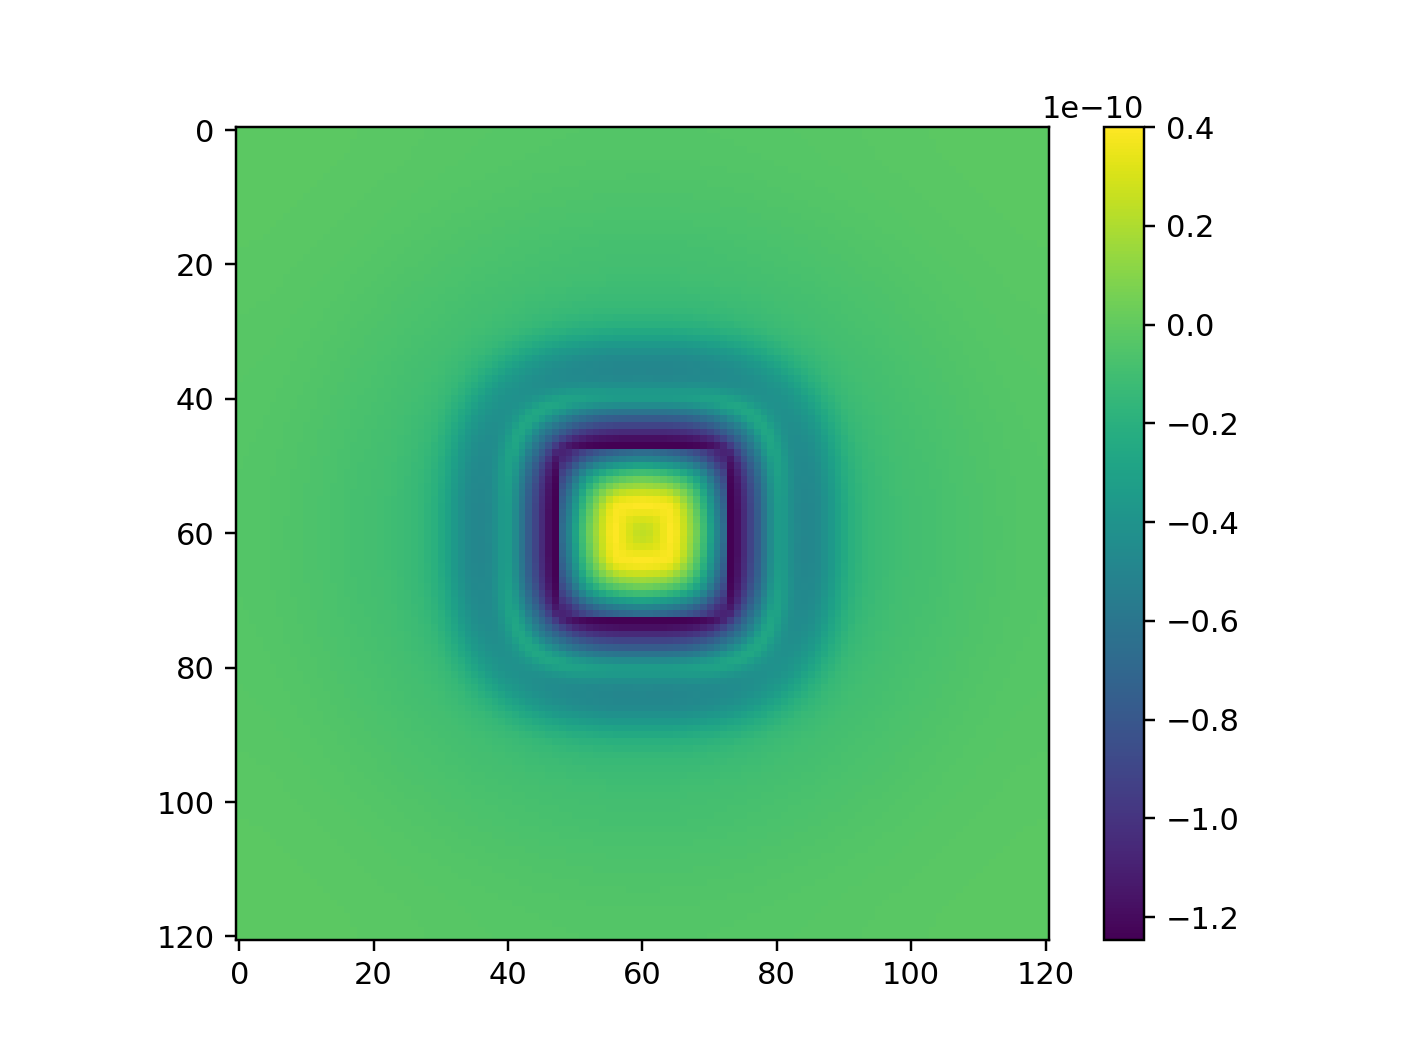

In [4]:
%matplotlib notebook
v1_p1 = np.genfromtxt("poort_results/V1_V_1.csv", delimiter=',')
v1_p0 = np.genfromtxt("poort_results/V1_V_2.csv", delimiter=',')
print(np.sum(v1_p1 - V1['V'][599][1]))
print(np.sum(v1_p0 - V1['V'][599][0]))
plt.imshow(np.mean([v1_p0,v1_p1], axis=0) - np.mean(V1['V'][599], axis=0))
plt.colorbar()

In [ ]:

plt.imshow(np.sum([v1_p0,v1_p1]))

In [5]:
print(np.sqrt(np.sum((v1_p1 - V1['V'][599][1])**2)))
print(np.sqrt(np.sum((v1_p0 - V1['V'][599][0])**2)))
print(np.sqrt(np.sum((np.mean([v1_p0,v1_p1], axis=0) - np.mean(V1['V'][599], axis=0))**2)))

2.555705714615719e-09
4.301361250337285e-09
3.2073942798583115e-09


In [ ]:
np.mean([v1_p0,v1_p1]) - np.mean(V1['V'][599], axis=0)

In [99]:
print(activity[1, 40:60:, 40:60])

[[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.  0.  0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
 [0.  0.  0.  0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
 [0.  0.  0.  0.  0.  0.1 0.1 0.2 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
 [0.  0.  0.  0.  0.  0.1 0.1 0.2 0.3 0.3 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
 [0.  0.  0.  0.  0.  0.1 0.2 0.2 0.3 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.  0.  0.  0.  0.  0.1 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.

In [39]:
V1_2_feedback = feedback_interp(V2['W'][1][0],
                                model.V1_X,
                                model.V1_Y,
                                model.V2_X,
                                model.V2_Y)
V1_4_feedback = feedback_interp(V4['W'][1][0],
                                model.V1_X,
                                model.V1_Y,
                                model.V4_X,
                                model.V4_Y)
activity = V1_2_feedback + V1_4_feedback
# V1_feedback = ndimage.correlate(activity, model.V1[0].fb_kernel, mode='nearest')

np.sum(activity)

0.044271608319089335

In [18]:
# np.sum(
# - model.V1[0].g3 * model.V1[0].D - model.V1[0].g4 * ndimage.correlate(
#             np.abs(V1['V'][40][0] - ndimage.correlate(V1['V'][40][0], model.V1[0].minus_kernel, mode='nearest'))
#         ,model.V1[0].plus_kernel, mode='nearest') * (V1['W'][39][0] - model.V1[0].e3)
# )
# X = - model.V1[0].g3 * 0 - model.V1[0].g4 * ndimage.correlate(
#     np.abs(V1['V'][40][0] - ndimage.correlate(V1['V'][40][0], model.V1[0].minus_kernel, mode='nearest')),
#     model.V1[0].plus_kernel, mode='nearest') * (V1['W'][39][0] - model.V1[0].e3)

X = model.V1[0].W_dot(V1['W'][0][0], V1['V'][1][0])
# np.sum(X)
np.sum(V1['W'][0][0] + 10e-3/2 * (X + model.V1[0].W_dot(V1['W'][0][0] + (10e-3*X), V1['V'][1][0])))
    

0.08284702180867959

In [156]:
parm_df = pd.read_csv("../parameters.csv", index_col=0)
parm_df.loc['k2'] = [0,0,0,0]
parm_df.loc['g8'] = [0,0,0,0]
print(parm_df.loc['k2'])

fg = 45
bg = 135
na = generate_block(bg_orientation=bg, figure_orientation=fg)

model = Model(parm_df,
             features=[bg,fg])

V1 = {"bck": [], "cen": [], "brd": []}
V4 = {"bck": [], "cen": [], "brd": []}
LGN = {"bck": [], "cen": [], "brd": []}

for i in range(600):
    if i < 40:
        model.update(None, 10e-3)
    else:
        model.update(na, 10e-3)
        
    LGN['bck'].append(np.mean(np.array([model.LGN[f].V for f in range(len(model.features))]), axis=0 ))
    V1['bck'].append(np.mean(np.array([model.V1[f].V for f in range(len(model.features))]), axis=0 ))
    V4['cen'].append(np.mean(np.array([model.V4[f].V for f in range(len(model.features))]), axis=0 ))


V1     0.0
V2     0.0
V4     0.0
FEF    0.0
Name: k2, dtype: float64


In [128]:
np.array(V1['V']).shape

(600, 2, 121, 121)

<IPython.core.display.Javascript object>


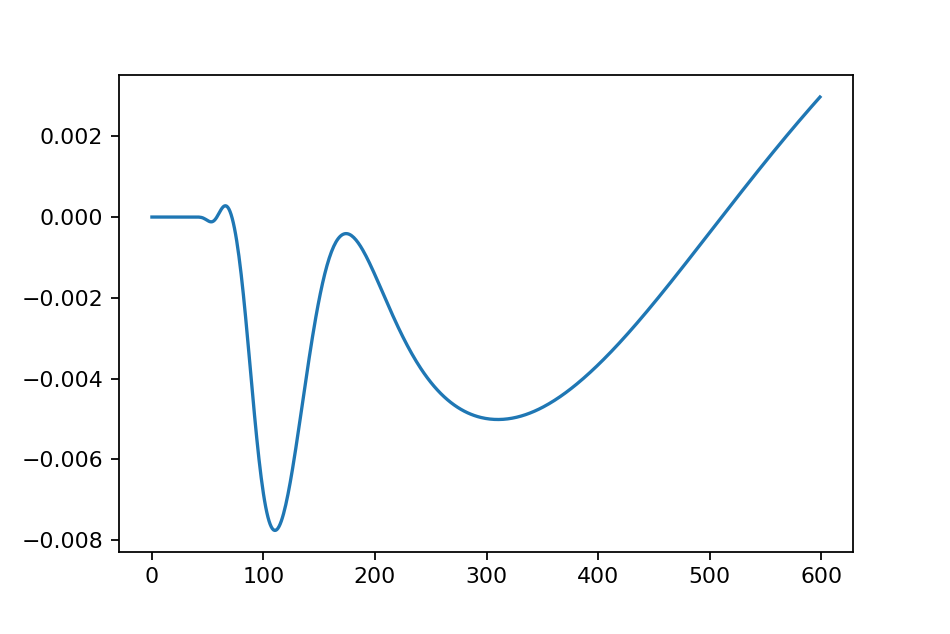

In [151]:
%matplotlib notebook
loc = 'brd'
LGN_act_p = pd.read_csv('poort_results/v1.csv')[loc]
LGN_act = np.mean(V1['V'], axis=(1))[:,48,48]
plt.plot(LGN_act_p - LGN_act)

<IPython.core.display.Javascript object>


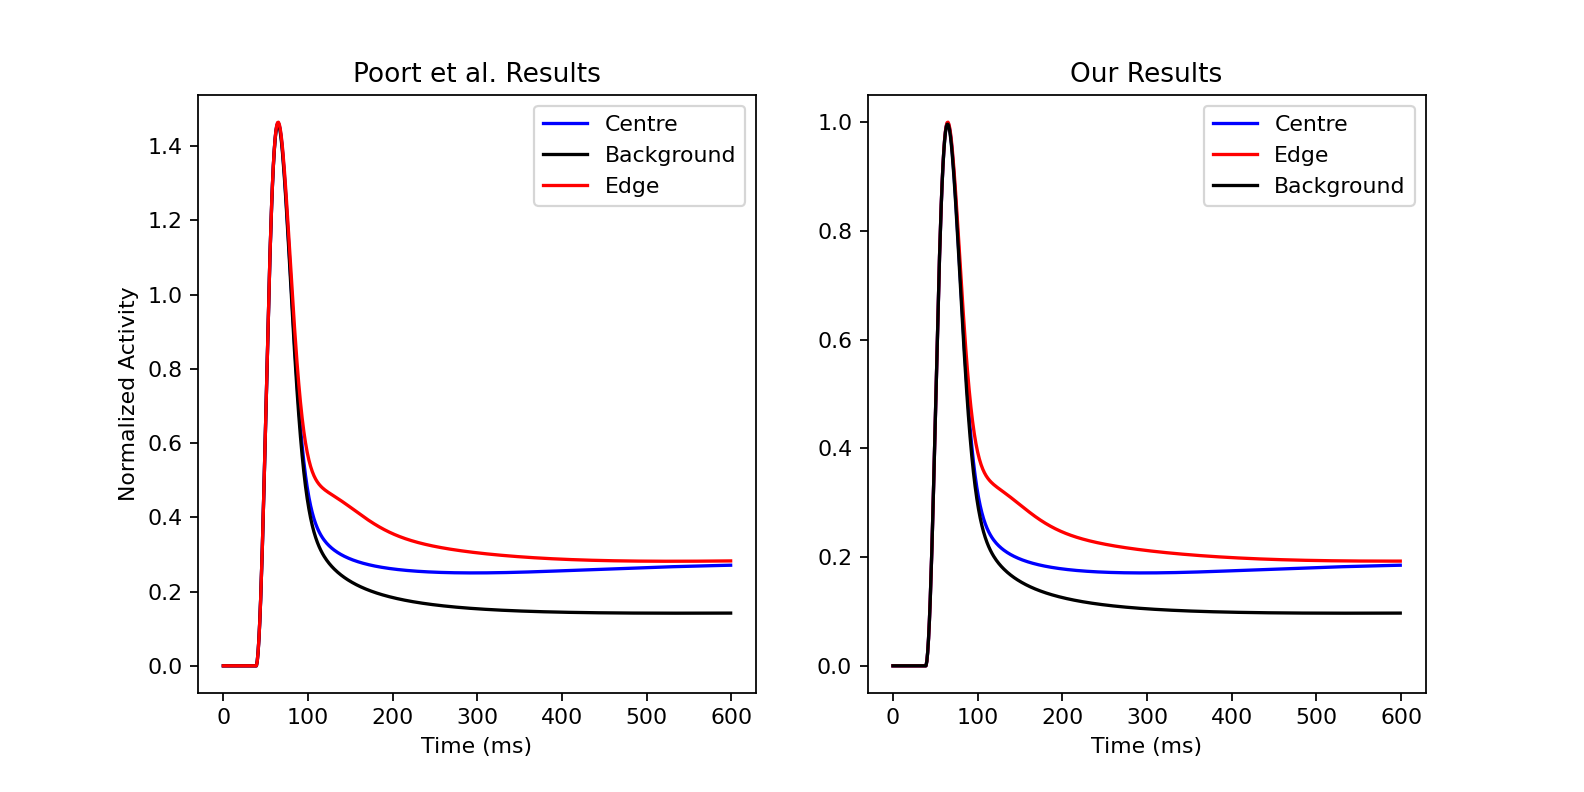

Text(0.5, 1.0, 'Our Results')

In [187]:
%matplotlib notebook
fig, axs = plt.subplots(1,2, figsize=(10, 5))
V1_act_p = pd.read_csv('poort_results/v1.csv')
axs[0].plot(V1_act_p['cen'] , 'b', label="Centre")
axs[0].plot(V1_act_p['bck'], 'k', label="Background")
axs[0].plot(V1_act_p['brd'], 'r', label="Edge")
axs[0].set_ylabel("Normalized Activity")
axs[0].set_xlabel("Time (ms)")
axs[0].legend()
axs[0].set_title("Poort et al. Results")

V1_act = np.array(V1['bck'])

V1_bck = V1_act[:,19,19]
V1_cen = V1_act[:,60,60]
V1_brd = V1_act[:,49,49]

maxV1 = np.amax([V1_bck, V1_cen, V1_brd])
axs[1].plot(V1_cen / maxV1, 'b', label="Centre")
axs[1].plot(V1_brd / maxV1, 'r', label="Edge")
axs[1].plot(V1_bck / maxV1, 'k', label="Background")
axs[1].legend()
# axs[1].ylabel("Normalized Activity")
axs[1].set_xlabel("Time (ms)")
axs[1].set_title("Our Results")


<IPython.core.display.Javascript object>


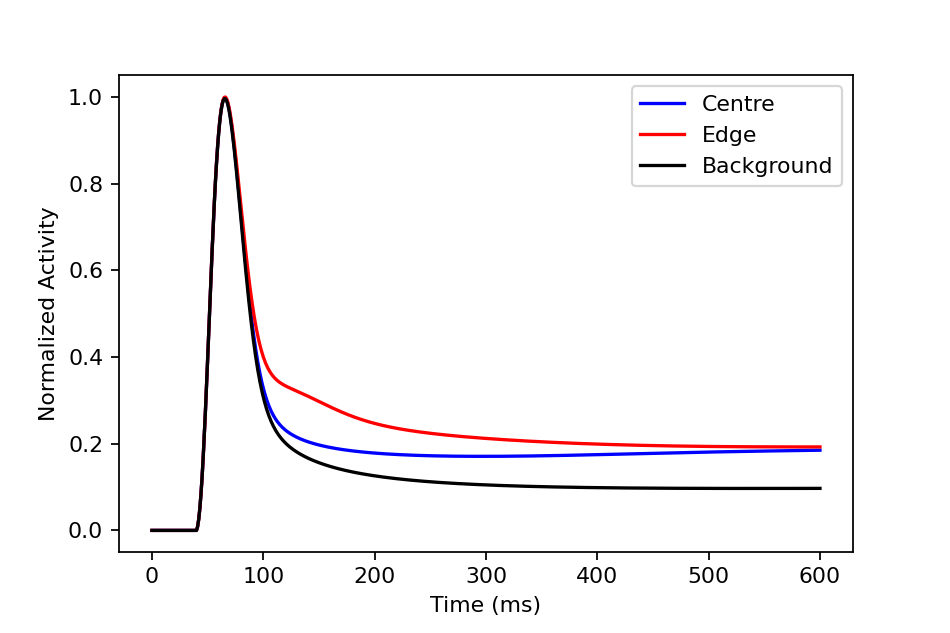

Text(0.5, 0, 'Time (ms)')

In [160]:
%matplotlib notebook
V1_act = np.array(V1['bck'])
zeros = np.repeat(0, 1)

V1_bck = V1_act[:,19,19]
V1_cen = V1_act[:,60,60]
V1_brd = V1_act[:,49,49]
V1_bck = np.hstack((zeros, V1_bck))
V1_cen = np.hstack((zeros, V1_cen))
V1_brd = np.hstack((zeros, V1_brd))

maxV1 = np.amax([V1_bck, V1_cen, V1_brd])
plt.plot(V1_cen / maxV1, 'b', label="Centre")
plt.plot(V1_brd / maxV1, 'r', label="Edge")
plt.plot(V1_bck / maxV1, 'k', label="Background")
plt.legend()
plt.ylabel("Normalized Activity")
plt.xlabel("Time (ms)")






<IPython.core.display.Javascript object>


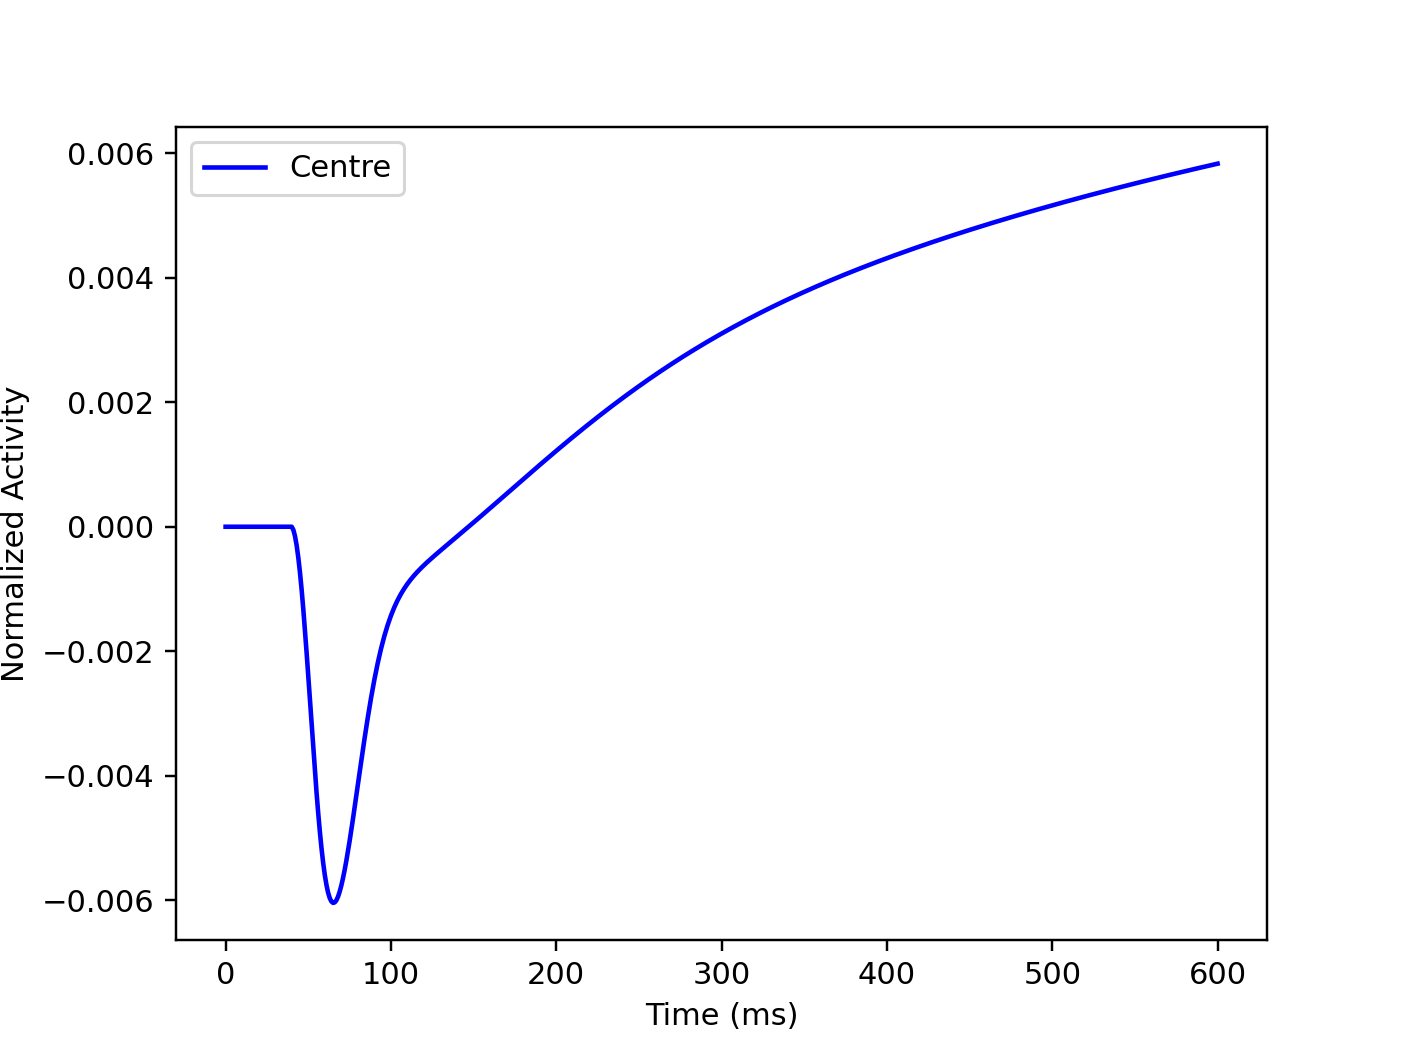

Text(0.5, 0, 'Time (ms)')

In [7]:
%matplotlib notebook
plt.plot(V1_bck / maxV1 - V1_bck_p / maxV1_p, 'b', label="Centre")
# plt.plot(V1_brd / maxV1, 'r', label="Edge")
# plt.plot(V1_bck / maxV1, 'k', label="Background")
plt.legend()
plt.ylabel("Normalized Activity")
plt.xlabel("Time (ms)")


In [11]:
np.array(V4['cen'])[0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.

<IPython.core.display.Javascript object>


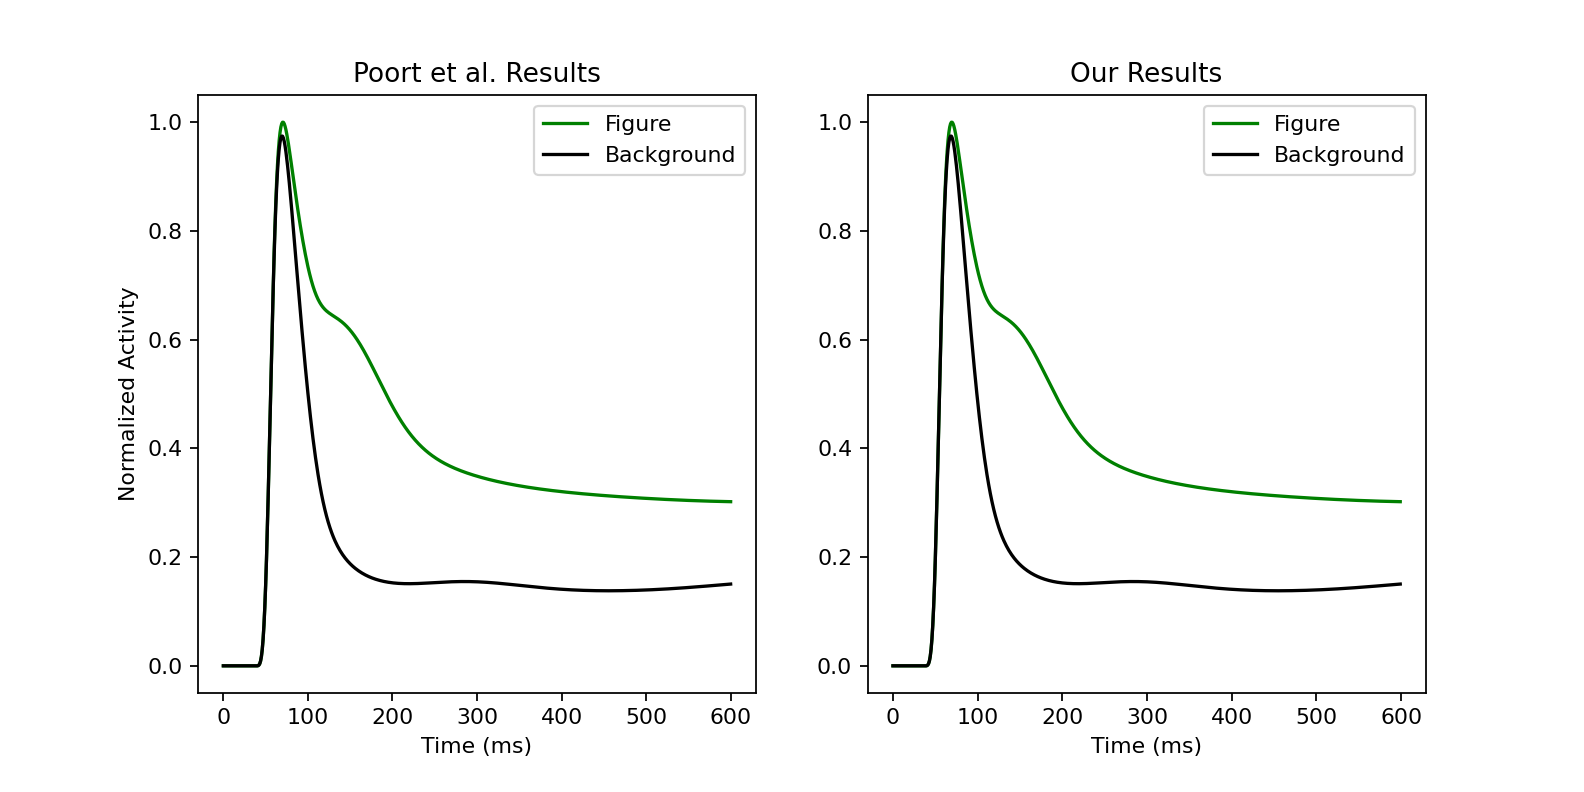

Text(0.5, 1.0, 'Our Results')

In [182]:
%matplotlib notebook
fig, axs = plt.subplots(1,2, figsize=(10, 5))
V4_act_p = pd.read_csv('poort_results/v4.csv')
axs[0].plot(V4_act_p['cen'] , 'g', label="Figure")
axs[0].plot(V4_act_p['bck'], 'k', label="Background")
axs[0].set_ylabel("Normalized Activity")
axs[0].set_xlabel("Time (ms)")
axs[0].legend()
axs[0].set_title("Poort et al. Results")

V4_cen =  np.array(V4['cen'])[:,7,7]
V4_bck = np.array(V4['cen'])[:,1,1]
maxV4 = np.amax([V4_bck, V4_cen])
axs[1].plot(V4_cen / maxV4, 'g', label="Figure")
axs[1].plot(V4_bck / maxV4, 'k', label="Background")
# axs[1].set_ylabel("Normalized Activity")
axs[1].set_xlabel("Time (ms)")
axs[1].legend()
axs[1].set_title("Our Results")

<IPython.core.display.Javascript object>


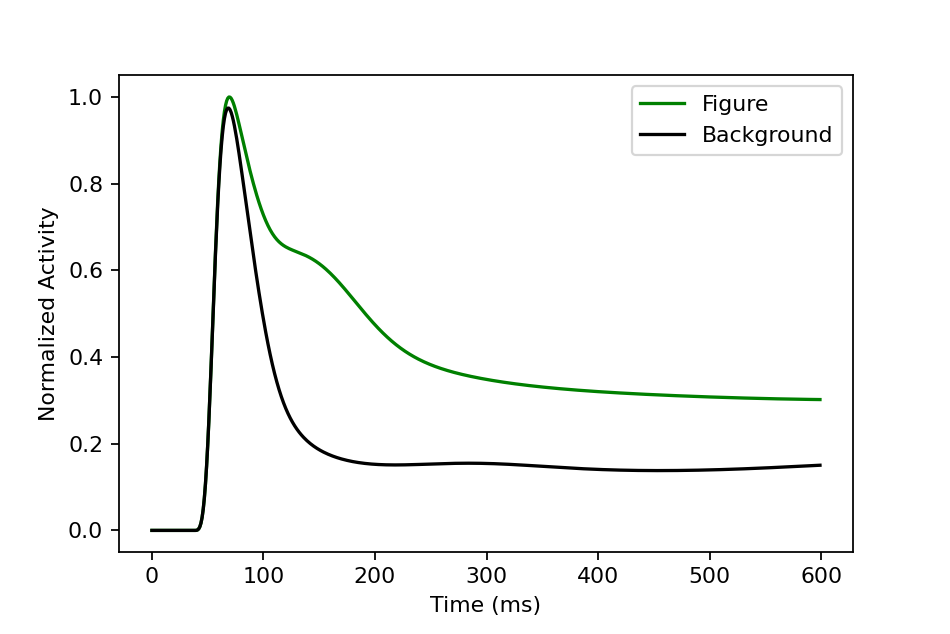

In [169]:
V4_cen =  np.array(V4['cen'])[:,7,7]
V4_bck = np.array(V4['cen'])[:,1,1]
maxV4 = np.amax([V4_bck, V4_cen])
plt.plot(V4_cen / maxV4, 'g', label="Figure")
plt.plot(V4_bck / maxV4, 'k', label="Background")
plt.ylabel("Normalized Activity")
plt.xlabel("Time (ms)")
plt.legend()

In [ ]:
f, axs = plt.subplots(1,len(exps.keys()), figsize=(20,5))

    V4 = np.array(results[exp]["full"])
    bck = V4[:,1,1]
    cen = np.mean(V4[:,16:22, 20:26], axis=(1,2))
    maxV4 = np.amax([bck,cen])
    axs[i].plot(bck / maxV4, 'k', label="background")
    axs[i].plot(cen / maxV4, 'r', label="center")
    axs[i].title.set_text(f"Activity for orientation difference of {exp}")
    axs[i].legend()




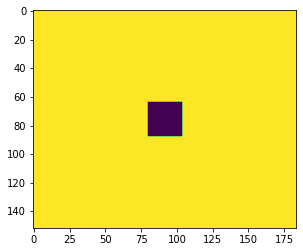

In [42]:
%matplotlib inline
parm_df = pd.read_csv("../parameters.csv", index_col=0)

sigma = 27
exps = {"90°": [135, 45], "20°": [135, 115]}#, "60°": [75, 135]} #, "75°": [75, 135], "90°": [75, 135]}
results = {k: {"bck": [], "cen": [], "full": [], "cenblock": [], 
               "bck_act": [], "fig_act": [], "S": [], "W": [], "V": []
              , "W1": [], "V1": [], "V2": [], "V4": []} for k in exps.keys()}
# parm_df.loc['rf_wdith', 'LGN'] = 5
for exp, orientations in exps.items():
    bg = orientations[0]
    fg = orientations[1]
    
    na = generate_block(input_dim=(152, 184), bg_orientation=bg, figure_orientation=fg)#, figure_dim=(8,8), midpoint=(22,22))
    model = Model(parm_df, 
                  input_dim=(152, 184),
                  features=[bg, fg], 
                  similarity_width=sigma)#, 
#                   image=na)


    n = 600
    empty = None
    for i in range(n):
        if i < 39:  
            model.update(empty, 10e-3)
        else: 
            model.update(na, 10e-3)

        results[exp]["S"].append(model.V1[0].S)
        results[exp]["W"].append(model.V1[0].W)
        results[exp]["W1"].append(model.V1[1].W)
        results[exp]["V"].append(model.V1[0].V)
        results[exp]["fig_act"].append(model.V4[1].V)
        results[exp]["bck"].append(np.mean( np.array([ model.V4[f].V[1,1] for f in range(len(model.features))]), axis=0 ))
        results[exp]["cen"].append(np.mean( np.array([ model.V4[f].V[model.V4[f].cen_x, model.V4[f].cen_y] for f in range(len(model.features))]), axis=0 ))
        results[exp]["cenblock"].append(np.mean([ model.V4[f].V[7,7] for f in range(len(model.features))]))
        results[exp]["full"].append(np.mean( np.array([ model.V4[f].V for f in range(len(model.features))]), axis=0 ))
        results[exp]["V4"].append(np.mean(np.array([model.V4[f].V for f in range(len(model.features))]), axis=0 ))
        results[exp]["V1"].append(np.mean(np.array([model.V1[f].V for f in range(len(model.features))]), axis=0 ))
        results[exp]["V2"].append(np.mean(np.array([model.V2[f].V for f in range(len(model.features))]), axis=0 ))

plt.imshow(na)

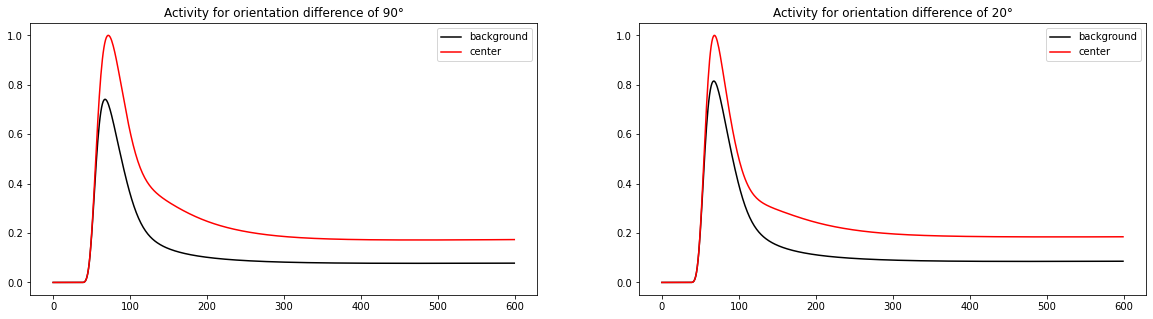

In [60]:
%matplotlib inline


f, axs = plt.subplots(1,len(exps.keys()), figsize=(20,5))

for i in range(len(exps.keys())):
    exp = list(exps.keys())[i]
    V4 = np.array(results[exp]["full"])
    bck = V4[:,1,1]
    cen = np.mean(V4[:,16:22, 20:26], axis=(1,2))
    maxV4 = np.amax([bck,cen])
    axs[i].plot(bck / maxV4, 'k', label="background")
    axs[i].plot(cen / maxV4, 'r', label="center")
    axs[i].title.set_text(f"Activity for orientation difference of {exp}")
    axs[i].legend()





<IPython.core.display.Javascript object>


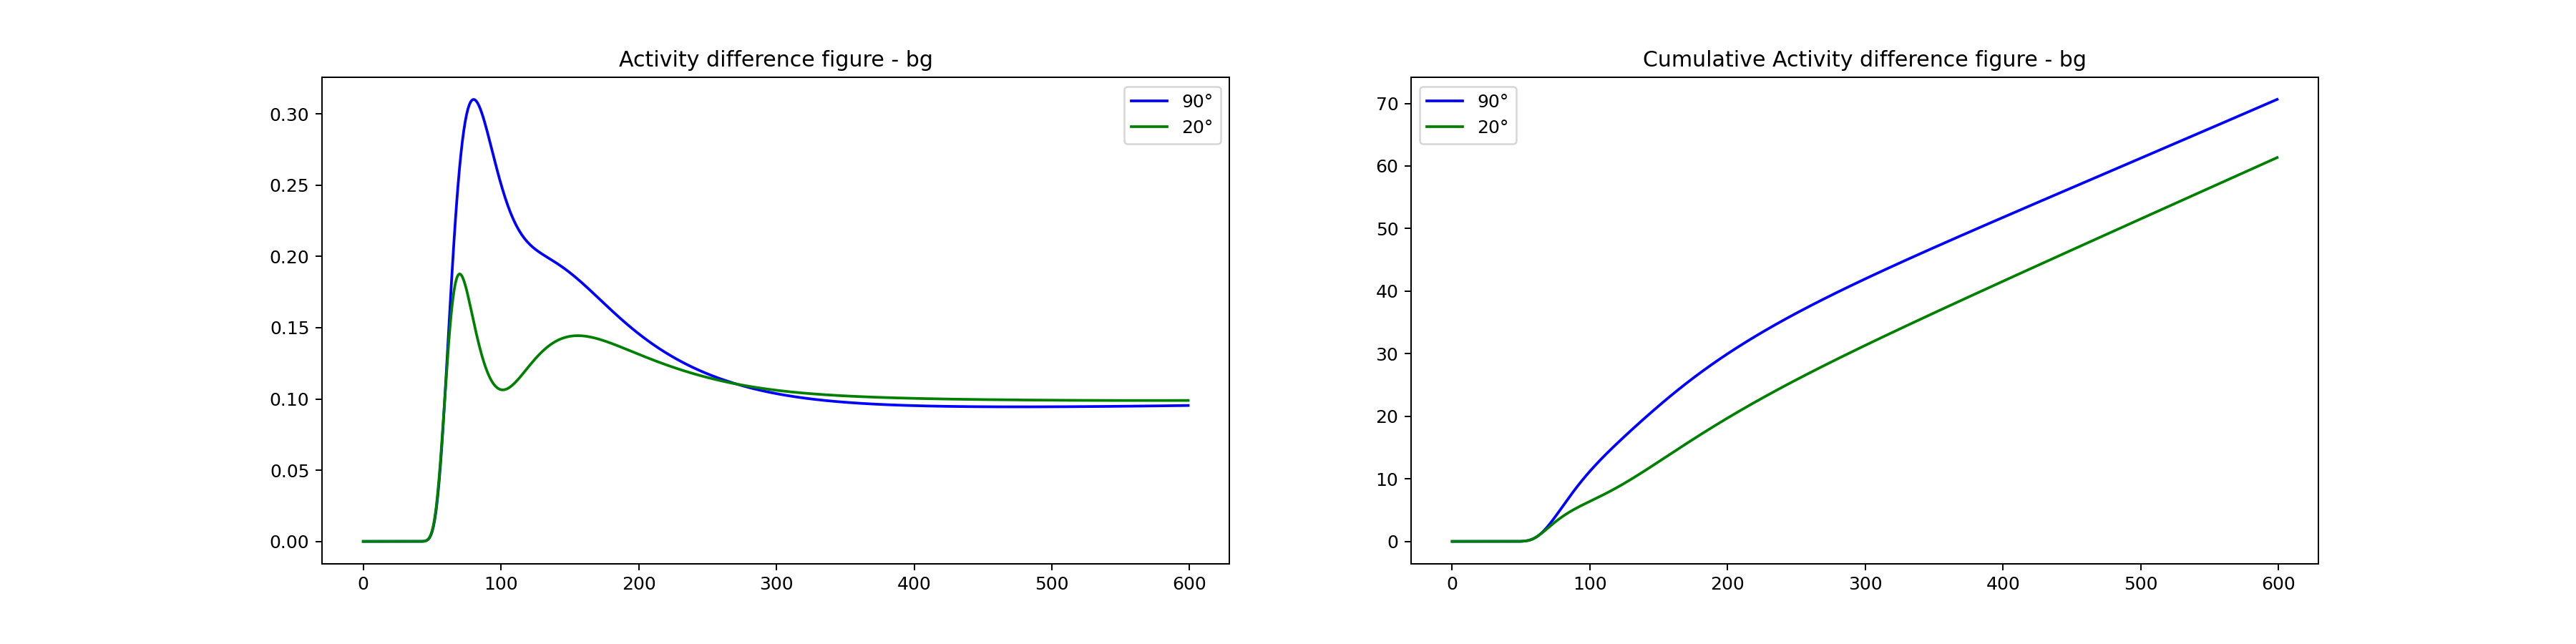

In [59]:
f, axs = plt.subplots(1,2, figsize=(20,5))

exps_colours = ['b', 'g', 'm', 'y', 'k']

for i in range(len(exps.keys())):
    exp = list(exps.keys())[i]
    V4 = np.array(results[exp]["full"])
    bck = V4[:,1,1]
    cen = np.mean(V4[:,16:22, 20:26], axis=(1,2))
    maxV4 = np.amax([bck, cen])
    diff = cen / maxV4 - bck / maxV4
    axs[0].plot(diff, exps_colours[i], label=exp)
    axs[0].legend()
    axs[0].title.set_text("Activity difference figure - bg")
    
    axs[1].plot(np.cumsum(diff), exps_colours[i], label=exp)
    axs[1].legend()
    axs[1].title.set_text("Cumulative Activity difference figure - bg")



In [19]:
percs_r = [0.606, 0.318, 0.918 ]
percs_b = [0.402, 0.432, 0.899 ]
print([255 * perc for perc in percs_r])
print([255 * perc for perc in percs_b])
# 0.4250 * 255

[154.53, 81.09, 234.09]
[102.51, 110.16, 229.245]


<IPython.core.display.Javascript object>


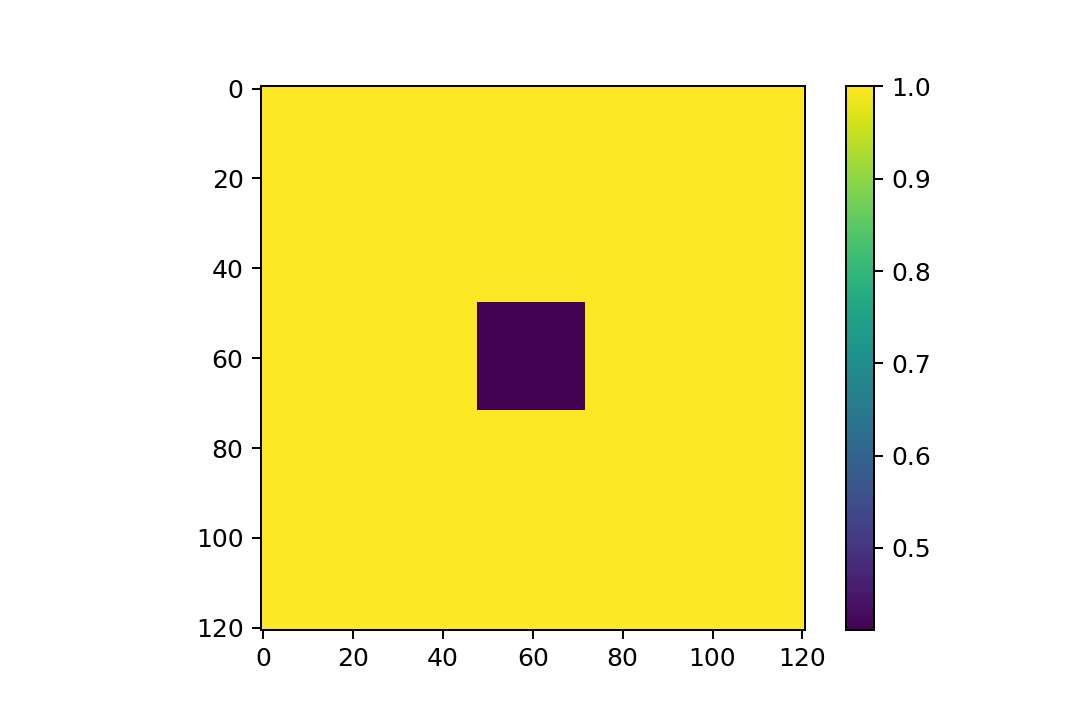

In [13]:
bg = 135
fg = 115
na = generate_block(bg_orientation=bg, figure_orientation=fg) #, figure_dim=(8,8), midpoint=(20,20))
activity = gaussian_1d(np.abs(bg - na), 0, 15)
# plt.imshow(border_detection(activity, np.ones_like(activity), 9, 2, 5, 1))
plt.imshow(activity)
plt.colorbar()

In [8]:
def border_detection(activity, scale, minus_support, minus_sigma, plus_support, plus_sigma):
    return ndimage.correlate(
            abs(activity - ndimage.correlate(activity, gaussian_kernel(minus_support, minus_sigma), mode='nearest')),
            gaussian_kernel(plus_support, plus_sigma), mode='nearest')

<IPython.core.display.Javascript object>


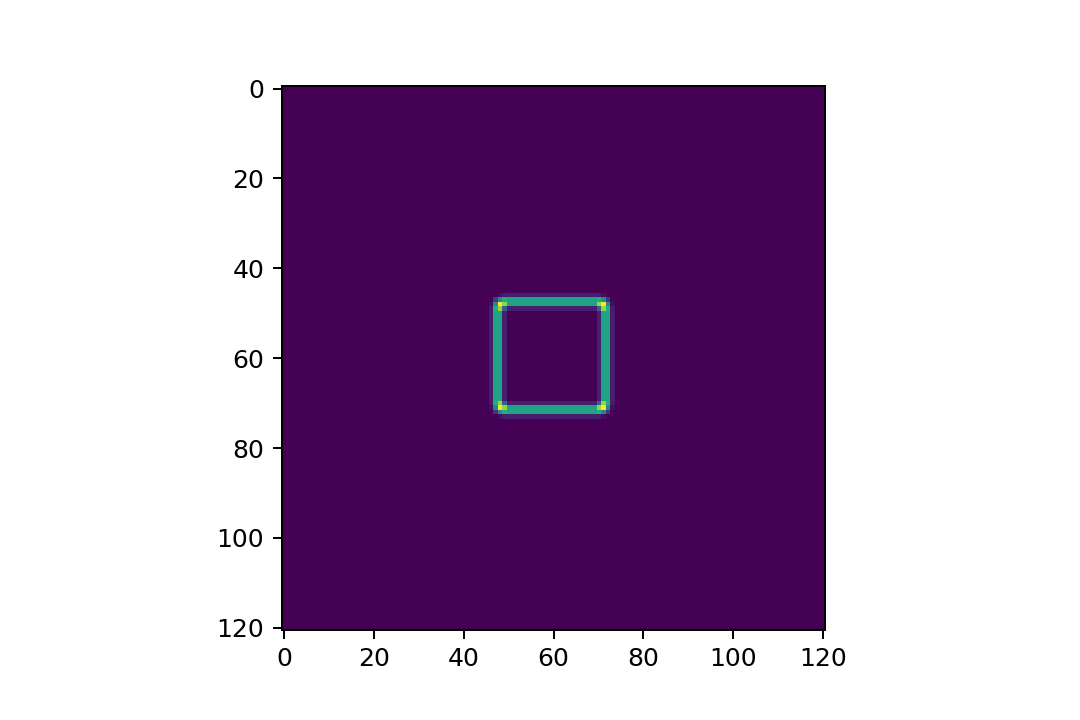

In [6]:
%matplotlib notebook
plt.imshow(model.V1_similarity_scales[0])

In [8]:
gaussian_1d(135 - 45, 0.0, 27)

0.0038659201394728076

In [3]:
gaussian_1d(135 - 115, 0.0, 27)

0.7600672046071237

<IPython.core.display.Javascript object>


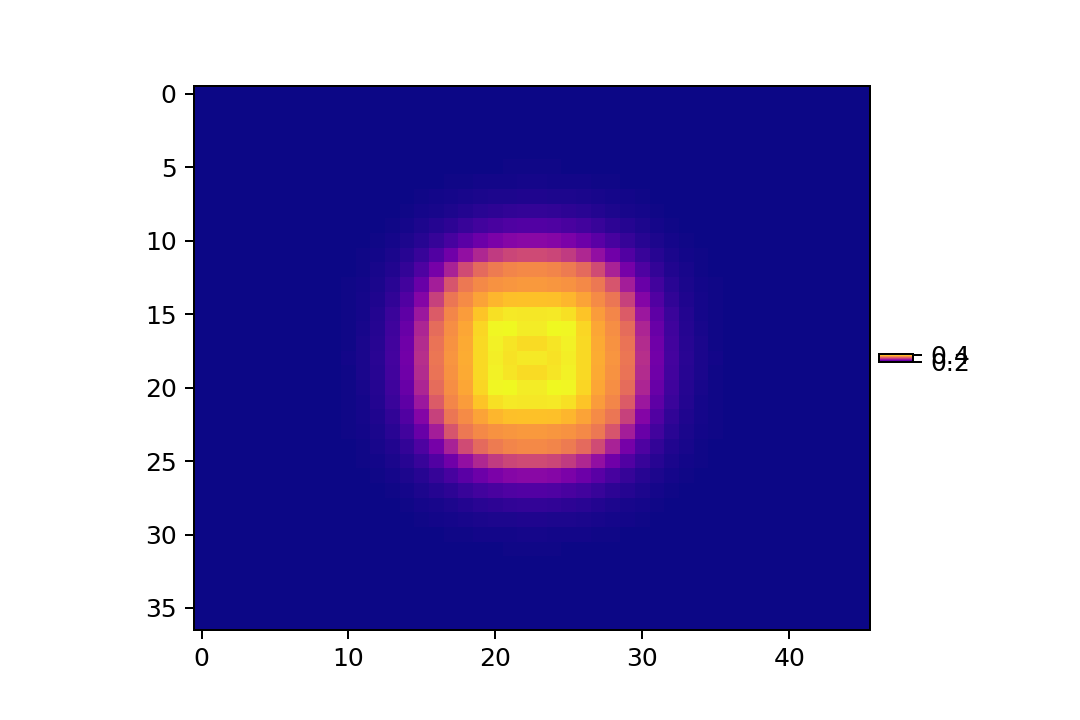

(37, 46)


In [4]:
%matplotlib notebook
# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame

activity = np.array(results["20°"]["V4"])#gaussian_1d(135 - 115, 0.0, 27) * np.array(results["20°"]["W"]) * np.array(results["20°"]["W1"])
fig, ax = plt.subplots()
ims = []
for i in range(600):
    im = ax.imshow(activity[i], cmap=cmap, animated=True)
    if i == 0:
        print(activity[i].shape)
        ax.imshow(activity[i], cmap=cmap)  # show an initial one first
    ims.append([im])
ani = animation.ArtistAnimation(fig, ims, interval=10, blit=True,
                                repeat_delay=1000)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# ani.save("background.mp4")

plt.colorbar(im, cax=cax)
ani

<IPython.core.display.Javascript object>


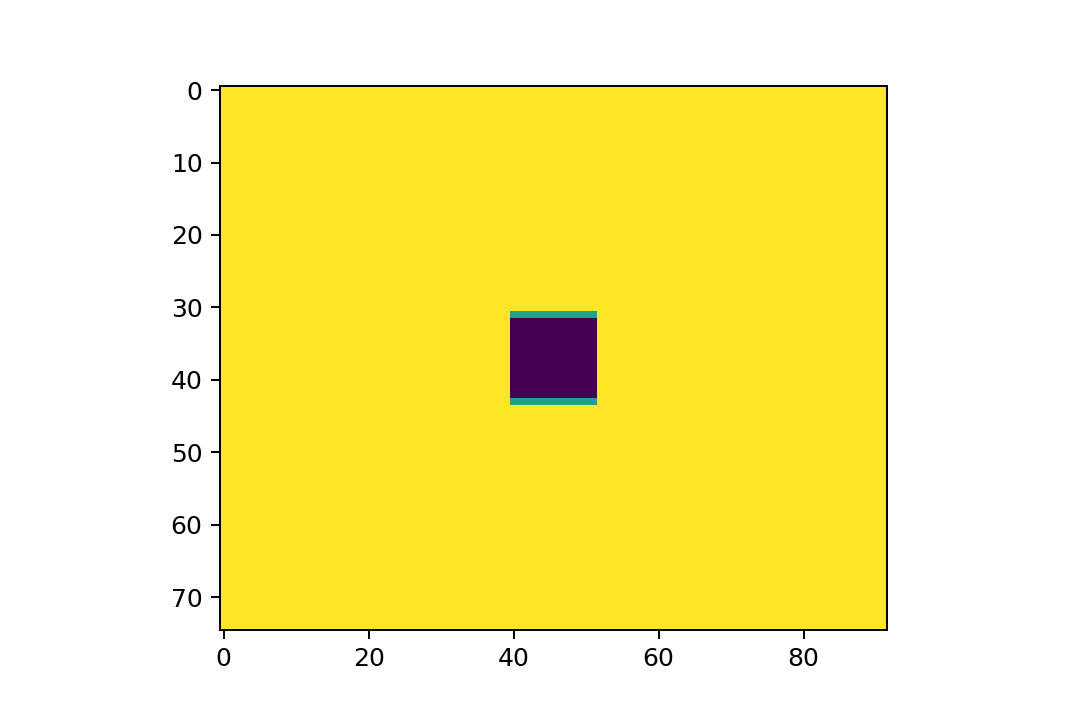

In [22]:
plt.imshow(activity[300,8:30,15:30])

In [28]:
184 / 2

92.0

<IPython.core.display.Javascript object>


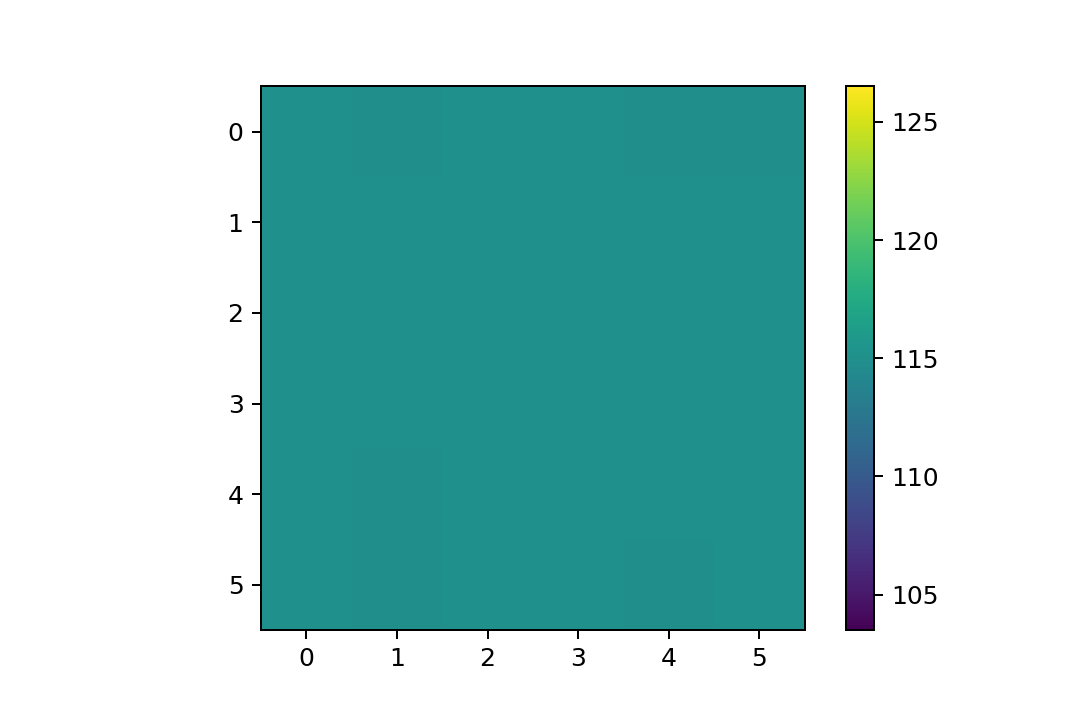

In [58]:
%matplotlib notebook
# fig, axs = plt.subplots(1,2, figsize=(20,10))
x_dim = 152
na = generate_block(input_dim=(x_dim, 184), bg_orientation=bg, figure_orientation=fg)
model = Model(parm_df, 
                  input_dim=(x_dim, 184),
                  features=[bg, fg], 
                  similarity_width=sigma)#, 
# axs[0].imshow(na)
f = interpolate.interp2d(model.V1_X, model.V1_Y, na)
V2_na = f(model.V2_X, model.V2_Y)
# axs[1].imshow(V2_na)

# print(na.shape, V2_na.shape)
# plt.imshow(V2_na)
# plt.colorbar()

g = interpolate.interp2d(model.V2_X, model.V2_Y, V2_na)
V4_na = g(model.V4_X, model.V4_Y)

plt.imshow(V4_na[16:22, 20:26])
plt.colorbar()

In [64]:
(3 * (201 / 40 * 180)   - 225 ) / 60

41.47500000000001